In [133]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib
from collections import defaultdict
import time

In [134]:
class BlackjackTDAgent:
    """Clase base para agentes de diferencias temporales en Blackjack"""

    def __init__(self, env, alpha=0.1, gamma=1.0, epsilon=0.1, epsilon_decay=0.9999, min_epsilon=0.01):
        self.env = env
        self.alpha = alpha  # Tasa de aprendizaje
        self.gamma = gamma  # Factor de descuento
        self.epsilon = epsilon  # Parámetro de exploración
        self.epsilon_decay = epsilon_decay  # Decaimiento de epsilon
        self.min_epsilon = min_epsilon  # Epsilon mínimo

        # Función Q(s,a) inicializada a cero
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))

        # Métricas de entrenamiento
        self.episode_rewards = []
        self.episode_lengths = []
        self.win_rates = []
        self.epsilon_history = []
        self.q_value_changes = []

    def epsilon_greedy_policy(self, state):
        """Política epsilon-greedy basada en Q(s,a)"""
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.env.action_space.n)  # Explorar
        else:
            return np.argmax(self.Q[state])  # Explotar

    def get_greedy_policy(self):
        """Obtiene la política greedy actual"""
        policy = {}
        for state in self.Q:
            policy[state] = np.argmax(self.Q[state])
        return policy

    def evaluate_policy(self, num_episodes=10000):
        """Evalúa la política greedy actual con métricas detalladas"""
        policy = self.get_greedy_policy()
        total_reward = 0
        wins = 0
        draws = 0
        losses = 0
        total_steps = 0

        for _ in range(num_episodes):
            state, _ = self.env.reset()
            done = False
            episode_reward = 0
            episode_steps = 0

            while not done:
                action = policy.get(state, 0)  # Acción por defecto = stick
                state, reward, terminated, truncated, _ = self.env.step(action)
                episode_reward += reward
                episode_steps += 1
                done = terminated or truncated

            total_reward += episode_reward
            total_steps += episode_steps

            # Clasificar resultado del episodio
            if episode_reward > 0:
                wins += 1
            elif episode_reward == 0:
                draws += 1
            else:
                losses += 1

        avg_reward = total_reward / num_episodes
        win_rate = wins / num_episodes
        draw_rate = draws / num_episodes
        loss_rate = losses / num_episodes
        avg_steps = total_steps / num_episodes

        return {
            'avg_reward': avg_reward,
            'win_rate': win_rate,
            'draw_rate': draw_rate,
            'loss_rate': loss_rate,
            'avg_steps': avg_steps,
            'total_episodes': num_episodes
        }

    def decay_epsilon(self):
        """Decaimiento de epsilon"""
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

    def train(self, num_episodes, eval_interval=1000, verbose=True):
        """Método de entrenamiento (a implementar en subclases)"""
        raise NotImplementedError

In [135]:
class MonteCarloAgent(BlackjackTDAgent):
    """Agente Monte Carlo - Control con exploración epsilon-greedy"""

    def __init__(self, env, alpha=None, gamma=1.0, epsilon=0.1, epsilon_decay=0.9999, min_epsilon=0.01):
        # Llamar al constructor padre pero ignorar alpha (Monte Carlo no usa tasa de aprendizaje incremental)
        super().__init__(env, alpha=0.0, gamma=gamma, epsilon=epsilon, epsilon_decay=epsilon_decay, min_epsilon=min_epsilon)

        # Estructuras específicas para Monte Carlo
        self.returns_sum = defaultdict(float)
        self.returns_count = defaultdict(float)

    def train(self, num_episodes, eval_interval=1000, verbose=True):
        """Entrenamiento Monte Carlo con primera visita"""
        if verbose:
            print("Entrenando agente Monte Carlo...")

        start_time = time.time()

        for episode in range(1, num_episodes + 1):
            # Generar episodio completo
            episode_data = []
            state, _ = self.env.reset()
            done = False
            episode_reward = 0
            episode_length = 0

            # Recolectar episodio completo
            while not done:
                action = self.epsilon_greedy_policy(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                episode_data.append((state, action, reward))
                state = next_state
                episode_reward += reward
                episode_length += 1
                done = terminated or truncated

            # Actualización Monte Carlo (primera visita)
            G = 0
            visited_state_actions = set()
            q_changes = []

            # Procesar episodio hacia atrás
            for state, action, reward in reversed(episode_data):
                G = self.gamma * G + reward

                # Primera visita: solo actualizar si no hemos visto este (s,a) antes en este episodio
                if (state, action) not in visited_state_actions:
                    # Guardar valor Q anterior para medir cambios
                    old_q = self.Q[state][action]

                    # Actualización Monte Carlo: promedio incremental
                    self.returns_sum[(state, action)] += G
                    self.returns_count[(state, action)] += 1.0
                    self.Q[state][action] = self.returns_sum[(state, action)] / self.returns_count[(state, action)]

                    # Registrar cambio en Q
                    q_changes.append(abs(self.Q[state][action] - old_q))

                    visited_state_actions.add((state, action))

            # Registrar métricas
            self.episode_rewards.append(episode_reward)
            self.episode_lengths.append(episode_length)
            self.epsilon_history.append(self.epsilon)
            self.q_value_changes.append(np.mean(q_changes) if q_changes else 0)

            # Decaimiento de epsilon
            self.decay_epsilon()

            # Evaluación periódica
            if episode % eval_interval == 0:
                eval_results = self.evaluate_policy(num_episodes=5000)
                self.win_rates.append((episode, eval_results))

                if verbose:
                    elapsed = time.time() - start_time
                    print(f"Episodio {episode:6d} | Reward: {eval_results['avg_reward']:6.3f} | "
                          f"Win: {eval_results['win_rate']:5.1%} | "
                          f"Draw: {eval_results['draw_rate']:5.1%} | "
                          f"Loss: {eval_results['loss_rate']:5.1%} | "
                          f"Steps: {eval_results['avg_steps']:4.1f} | "
                          f"ε: {self.epsilon:.4f} | Tiempo: {elapsed:.1f}s")

        if verbose:
            total_time = time.time() - start_time
            print(f"Entrenamiento Monte Carlo completado en {total_time:.1f}s")

In [136]:
class SARSAAgent(BlackjackTDAgent):
    """Agente SARSA(0) - On-policy TD Control"""

    def train(self, num_episodes, eval_interval=1000, verbose=True):
        """Entrenamiento SARSA(0)"""
        if verbose:
            print("Entrenando agente SARSA(0)...")

        start_time = time.time()

        for episode in range(1, num_episodes + 1):
            # Inicializar episodio
            state, _ = self.env.reset()
            action = self.epsilon_greedy_policy(state)

            episode_reward = 0
            episode_length = 0
            q_changes = []

            done = False
            while not done:
                # Ejecutar acción
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                episode_reward += reward
                episode_length += 1

                if not done:
                    # Seleccionar siguiente acción usando política actual
                    next_action = self.epsilon_greedy_policy(next_state)

                    # Actualización SARSA: Q(s,a) ← Q(s,a) + α[r + γQ(s',a') - Q(s,a)]
                    old_q = self.Q[state][action]
                    td_target = reward + self.gamma * self.Q[next_state][next_action]
                    td_error = td_target - old_q
                    self.Q[state][action] += self.alpha * td_error

                    q_changes.append(abs(td_error))

                    # Transición al siguiente estado-acción
                    state = next_state
                    action = next_action
                else:
                    # Estado terminal: Q(s',a') = 0
                    old_q = self.Q[state][action]
                    td_target = reward
                    td_error = td_target - old_q
                    self.Q[state][action] += self.alpha * td_error

                    q_changes.append(abs(td_error))

            # Registrar métricas
            self.episode_rewards.append(episode_reward)
            self.episode_lengths.append(episode_length)
            self.epsilon_history.append(self.epsilon)
            self.q_value_changes.append(np.mean(q_changes) if q_changes else 0)

            # Decaimiento de epsilon
            self.decay_epsilon()

            # Evaluación periódica
            if episode % eval_interval == 0:
                eval_results = self.evaluate_policy(num_episodes=5000)
                self.win_rates.append((episode, eval_results))

                if verbose:
                    elapsed = time.time() - start_time
                    print(f"Episodio {episode:6d} | Reward: {eval_results['avg_reward']:6.3f} | "
                          f"Win: {eval_results['win_rate']:5.1%} | "
                          f"Draw: {eval_results['draw_rate']:5.1%} | "
                          f"Loss: {eval_results['loss_rate']:5.1%} | "
                          f"Steps: {eval_results['avg_steps']:4.1f} | "
                          f"ε: {self.epsilon:.4f} | Tiempo: {elapsed:.1f}s")

        if verbose:
            total_time = time.time() - start_time
            print(f"Entrenamiento SARSA completado en {total_time:.1f}s")

In [137]:
class QLearningAgent(BlackjackTDAgent):
    """Agente Q-Learning - Off-policy TD Control"""

    def train(self, num_episodes, eval_interval=1000, verbose=True):
        """Entrenamiento Q-Learning"""
        if verbose:
            print("Entrenando agente Q-Learning...")

        start_time = time.time()

        for episode in range(1, num_episodes + 1):
            # Inicializar episodio
            state, _ = self.env.reset()

            episode_reward = 0
            episode_length = 0
            q_changes = []

            done = False
            while not done:
                # Seleccionar acción usando política epsilon-greedy
                action = self.epsilon_greedy_policy(state)

                # Ejecutar acción
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                episode_reward += reward
                episode_length += 1

                if not done:
                    # Actualización Q-Learning: Q(s,a) ← Q(s,a) + α[r + γ max_a' Q(s',a') - Q(s,a)]
                    old_q = self.Q[state][action]
                    td_target = reward + self.gamma * np.max(self.Q[next_state])
                    td_error = td_target - old_q
                    self.Q[state][action] += self.alpha * td_error

                    q_changes.append(abs(td_error))
                else:
                    # Estado terminal: max Q(s',a') = 0
                    old_q = self.Q[state][action]
                    td_target = reward
                    td_error = td_target - old_q
                    self.Q[state][action] += self.alpha * td_error

                    q_changes.append(abs(td_error))

                # Transición al siguiente estado
                state = next_state

            # Registrar métricas
            self.episode_rewards.append(episode_reward)
            self.episode_lengths.append(episode_length)
            self.epsilon_history.append(self.epsilon)
            self.q_value_changes.append(np.mean(q_changes) if q_changes else 0)

            # Decaimiento de epsilon
            self.decay_epsilon()

            # Evaluación periódica
            if episode % eval_interval == 0:
                eval_results = self.evaluate_policy(num_episodes=5000)
                self.win_rates.append((episode, eval_results))

                if verbose:
                    elapsed = time.time() - start_time
                    print(f"Episodio {episode:6d} | Reward: {eval_results['avg_reward']:6.3f} | "
                          f"Win: {eval_results['win_rate']:5.1%} | "
                          f"Draw: {eval_results['draw_rate']:5.1%} | "
                          f"Loss: {eval_results['loss_rate']:5.1%} | "
                          f"Steps: {eval_results['avg_steps']:4.1f} | "
                          f"ε: {self.epsilon:.4f} | Tiempo: {elapsed:.1f}s")

        if verbose:
            total_time = time.time() - start_time
            print(f"Entrenamiento Q-Learning completado en {total_time:.1f}s")

In [138]:
def plot_policy_comparison_three(sarsa_agent, qlearning_agent, mc_agent, usable_ace=True, figsize=(20, 8)):
    """Compara las políticas de los tres algoritmos"""

    plt.rcParams.update({'font.size': 10})

    fig, axes = plt.subplots(2, 3, figsize=figsize)
    fig.suptitle(f'Comparación de Políticas - Tres Algoritmos {"(Con As)" if usable_ace else "(Sin As)"}',
                 fontsize=16, fontweight='bold', y=0.98)

    player_sum = np.arange(4, 22)
    dealer_show = np.arange(1, 11)

    agents = [sarsa_agent, qlearning_agent, mc_agent]
    titles = ['SARSA', 'Q-Learning', 'Monte Carlo']

    policies = []

    # Fila superior: políticas individuales
    for idx, (agent, title) in enumerate(zip(agents, titles)):
        policy_Z = np.zeros((len(player_sum), len(dealer_show)))

        for i, ps in enumerate(player_sum):
            for j, ds in enumerate(dealer_show):
                state = (ps, ds, usable_ace)
                if state in agent.Q:
                    policy_Z[i, j] = np.argmax(agent.Q[state])

        policies.append(policy_Z)

        # Visualizar política
        colors_policy = ['#27ae60', '#e74c3c']  # Verde=Stick, Rojo=Hit
        cmap_policy = ListedColormap(colors_policy)

        im = axes[0, idx].imshow(policy_Z, origin='lower',
                                 extent=[0.5, 10.5, 3.5, 21.5],
                                 cmap=cmap_policy, vmin=0, vmax=1, aspect='auto')

        axes[0, idx].set_title(f'Política {title}', fontweight='bold')
        axes[0, idx].set_xlabel('Carta Visible del Dealer')
        axes[0, idx].set_ylabel('Suma del Jugador')

        axes[0, idx].set_xticks(range(1, 11))
        axes[0, idx].set_xticklabels(['A', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
        axes[0, idx].set_yticks(range(4, 22))

        # Añadir texto en cada celda
        for i, ps in enumerate(player_sum):
            for j, ds in enumerate(dealer_show):
                action = 'S' if policy_Z[i, j] == 0 else 'H'
                axes[0, idx].text(j + 1, ps, action, ha='center', va='center',
                                  color='white', fontweight='bold', fontsize=8)

    # Fila inferior: mapas de diferencias
    diff_titles = ['Q-Learning - SARSA', 'Monte Carlo - SARSA', 'Monte Carlo - Q-Learning']
    diff_pairs = [(1, 0), (2, 0), (2, 1)]  # Índices de las políticas a comparar

    for idx, ((pol2_idx, pol1_idx), title) in enumerate(zip(diff_pairs, diff_titles)):
        diff_Z = policies[pol2_idx] - policies[pol1_idx]

        im_diff = axes[1, idx].imshow(diff_Z, origin='lower',
                                     extent=[0.5, 10.5, 3.5, 21.5],
                                     cmap='RdBu', vmin=-1, vmax=1, aspect='auto')

        axes[1, idx].set_title(f'Diferencias\n({title})', fontweight='bold')
        axes[1, idx].set_xlabel('Carta Visible del Dealer')
        axes[1, idx].set_ylabel('Suma del Jugador')

        axes[1, idx].set_xticks(range(1, 11))
        axes[1, idx].set_xticklabels(['A', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
        axes[1, idx].set_yticks(range(4, 22))

        # Añadir texto en diferencias
        for i, ps in enumerate(player_sum):
            for j, ds in enumerate(dealer_show):
                if diff_Z[i, j] != 0:
                    text = '+' if diff_Z[i, j] > 0 else '-'
                    color = 'white' if abs(diff_Z[i, j]) > 0.5 else 'black'
                    axes[1, idx].text(j + 1, ps, text, ha='center', va='center',
                                     color=color, fontweight='bold', fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    return fig

In [139]:
def plot_three_agents_comparison(sarsa_agent, qlearning_agent, mc_agent, figsize=(20, 12)):
    """Visualiza comparación entre los tres algoritmos: SARSA, Q-Learning y Monte Carlo"""

    plt.rcParams.update({
        'figure.facecolor': 'white',
        'axes.facecolor': '#f8f9fa',
        'axes.edgecolor': '#333333',
        'axes.grid': True,
        'grid.alpha': 0.3,
        'font.size': 11
    })

    fig, axes = plt.subplots(2, 3, figsize=figsize)
    fig.suptitle('Comparación Completa: SARSA vs Q-Learning vs Monte Carlo',
                 fontsize=16, fontweight='bold', y=0.98)

    # Extraer datos de los tres agentes
    agents = [sarsa_agent, qlearning_agent, mc_agent]
    labels = ['SARSA', 'Q-Learning', 'Monte Carlo']
    colors = ['blue', 'red', 'green']
    markers = ['o', 's', '^']

    all_episodes = []
    all_rewards = []
    all_wins = []
    all_draws = []
    all_losses = []
    all_steps = []

    for agent in agents:
        if agent.win_rates:
            episodes = [ep for ep, _ in agent.win_rates]
            metrics = [m for _, m in agent.win_rates]

            all_episodes.append(episodes)
            all_rewards.append([m['avg_reward'] for m in metrics])
            all_wins.append([m['win_rate'] for m in metrics])
            all_draws.append([m['draw_rate'] for m in metrics])
            all_losses.append([m['loss_rate'] for m in metrics])
            all_steps.append([m['avg_steps'] for m in metrics])

    # 1. RETORNO PROMEDIO POR EPISODIO
    for i, (episodes, rewards, label, color, marker) in enumerate(zip(all_episodes, all_rewards, labels, colors, markers)):
        axes[0,0].plot(episodes, rewards, marker=marker, label=label,
                       color=color, linewidth=2, markersize=5, linestyle='-')

    axes[0,0].set_title('1. Retorno Promedio por Episodio', fontweight='bold', fontsize=13)
    axes[0,0].set_xlabel('Episodio de Entrenamiento')
    axes[0,0].set_ylabel('Retorno Promedio')
    axes[0,0].legend(fontsize=10)
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

    # 2. TASA DE VICTORIA
    for i, (episodes, wins, label, color, marker) in enumerate(zip(all_episodes, all_wins, labels, colors, markers)):
        axes[0,1].plot(episodes, [w*100 for w in wins], marker=marker, label=label,
                       color=color, linewidth=2, markersize=5, linestyle='-')

    axes[0,1].set_title('2. Tasa de Victoria (%)', fontweight='bold', fontsize=13)
    axes[0,1].set_xlabel('Episodio de Entrenamiento')
    axes[0,1].set_ylabel('Tasa de Victoria (%)')
    axes[0,1].legend(fontsize=10)
    axes[0,1].grid(True, alpha=0.3)

    # 3. LONGITUD PROMEDIO DE EPISODIO
    for i, (episodes, steps, label, color, marker) in enumerate(zip(all_episodes, all_steps, labels, colors, markers)):
        axes[0,2].plot(episodes, steps, marker=marker, label=label,
                       color=color, linewidth=2, markersize=5, linestyle='-')

    axes[0,2].set_title('3. Longitud Promedio de Episodio', fontweight='bold', fontsize=13)
    axes[0,2].set_xlabel('Episodio de Entrenamiento')
    axes[0,2].set_ylabel('Pasos Promedio por Episodio')
    axes[0,2].legend(fontsize=10)
    axes[0,2].grid(True, alpha=0.3)

    # 4. COMPARACIÓN FINAL CON BARRAS
    final_evaluations = []
    for agent in agents:
        final_eval = agent.evaluate_policy(num_episodes=20000)
        final_evaluations.append(final_eval)

    x_pos = np.arange(len(labels))
    width = 0.25

    rewards_final = [eval_result['avg_reward'] for eval_result in final_evaluations]
    wins_final = [eval_result['win_rate']*100 for eval_result in final_evaluations]
    steps_final = [eval_result['avg_steps'] for eval_result in final_evaluations]

    # Gráfico de barras para retorno promedio
    bars1 = axes[1,0].bar(x_pos, rewards_final, width,
                          color=colors, alpha=0.7, label='Retorno Promedio')
    axes[1,0].set_title('Retorno Promedio Final', fontweight='bold')
    axes[1,0].set_ylabel('Retorno Promedio')
    axes[1,0].set_xticks(x_pos)
    axes[1,0].set_xticklabels(labels)
    axes[1,0].grid(True, alpha=0.3)

    # Añadir valores en las barras
    for bar, value in zip(bars1, rewards_final):
        axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                       f'{value:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

    # Gráfico de barras para tasa de victoria
    bars2 = axes[1,1].bar(x_pos, wins_final, width,
                          color=colors, alpha=0.7, label='Tasa Victoria (%)')
    axes[1,1].set_title('Tasa de Victoria Final (%)', fontweight='bold')
    axes[1,1].set_ylabel('Tasa de Victoria (%)')
    axes[1,1].set_xticks(x_pos)
    axes[1,1].set_xticklabels(labels)
    axes[1,1].grid(True, alpha=0.3)

    for bar, value in zip(bars2, wins_final):
        axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                       f'{value:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

    # Gráfico de barras para longitud de episodio
    bars3 = axes[1,2].bar(x_pos, steps_final, width,
                          color=colors, alpha=0.7, label='Pasos Promedio')
    axes[1,2].set_title('Longitud Promedio Final', fontweight='bold')
    axes[1,2].set_ylabel('Pasos Promedio')
    axes[1,2].set_xticks(x_pos)
    axes[1,2].set_xticklabels(labels)
    axes[1,2].grid(True, alpha=0.3)

    for bar, value in zip(bars3, steps_final):
        axes[1,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                       f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    return fig

In [140]:
def print_three_agents_comparison(sarsa_agent, qlearning_agent, mc_agent):
    """Imprime comparación detallada entre los tres algoritmos"""

    print("="*90)
    print("COMPARACIÓN COMPLETA: SARSA vs Q-Learning vs Monte Carlo")
    print("="*90)

    # Evaluación final con muchos episodios
    print("Evaluando políticas finales (30,000 episodios por algoritmo)...")
    sarsa_final = sarsa_agent.evaluate_policy(num_episodes=30000)
    qlearning_final = qlearning_agent.evaluate_policy(num_episodes=30000)
    mc_final = mc_agent.evaluate_policy(num_episodes=30000)

    agents_results = [
        ("SARSA", sarsa_final),
        ("Q-Learning", qlearning_final),
        ("Monte Carlo", mc_final)
    ]

    print("\n" + "="*60)
    print("1. RETORNO PROMEDIO POR EPISODIO")
    print("="*60)
    for name, result in agents_results:
        print(f"{name:12s} : {result['avg_reward']:8.4f}")

    # Encontrar el mejor
    best_reward = max(agents_results, key=lambda x: x[1]['avg_reward'])
    print(f"🏆 Mejor retorno: {best_reward[0]} ({best_reward[1]['avg_reward']:.4f})")

    print("\n" + "="*60)
    print("2. DISTRIBUCIÓN DE RESULTADOS")
    print("="*60)
    print("Algoritmo    │ Victoria │ Empate  │ Derrota │")
    print("─" * 50)
    for name, result in agents_results:
        print(f"{name:12s} │ {result['win_rate']*100:6.2f}%  │ {result['draw_rate']*100:6.2f}% │ {result['loss_rate']*100:6.2f}%  │")

    best_win = max(agents_results, key=lambda x: x[1]['win_rate'])
    print(f"🏆 Mayor tasa de victoria: {best_win[0]} ({best_win[1]['win_rate']*100:.2f}%)")

    print("\n" + "="*60)
    print("3. LONGITUD PROMEDIO DE EPISODIO")
    print("="*60)
    for name, result in agents_results:
        print(f"{name:12s} : {result['avg_steps']:6.2f} pasos")

    best_efficiency = min(agents_results, key=lambda x: x[1]['avg_steps'])
    print(f"⚡ Más eficiente: {best_efficiency[0]} ({best_efficiency[1]['avg_steps']:.2f} pasos)")

    print("\n" + "="*60)
    print("RANKING GENERAL")
    print("="*60)

    # Calcular ranking ponderado
    rankings = []
    for name, result in agents_results:
        score = (result['avg_reward'] * 0.4 +  # 40% retorno
                result['win_rate'] * 0.4 +       # 40% tasa victoria
                (1/result['avg_steps']) * 0.2)   # 20% eficiencia
        rankings.append((name, score, result))

    rankings.sort(key=lambda x: x[1], reverse=True)

    for i, (name, score, result) in enumerate(rankings, 1):
        medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉"
        print(f"{medal} {i}. {name:12s} - Score: {score:.4f}")

    print("\n" + "="*90)
    return sarsa_final, qlearning_final, mc_final

## Experimentacion

In [141]:
env = gym.make("Blackjack-v1", sab=True)

In [142]:
num_episodes = 100000
eval_interval = 2000

In [143]:
params = {
    'alpha': 0.1,
    'gamma': 1.0,
    'epsilon': 0.9,
    'epsilon_decay': 0.9999,
    'min_epsilon': 0.01
}

In [144]:
sarsa_agent = SARSAAgent(env, **params)
qlearning_agent = QLearningAgent(env, **params)
mc_agent = MonteCarloAgent(env, **params)

In [145]:
mc_agent.train(num_episodes=num_episodes, eval_interval=eval_interval)

Entrenando agente Monte Carlo...
Episodio   2000 | Reward: -0.121 | Win: 40.5% | Draw:  6.9% | Loss: 52.6% | Steps:  1.2 | ε: 0.7369 | Tiempo: 0.2s
Episodio   4000 | Reward: -0.125 | Win: 40.3% | Draw:  7.0% | Loss: 52.8% | Steps:  1.3 | ε: 0.6033 | Tiempo: 0.4s
Episodio   6000 | Reward: -0.104 | Win: 41.4% | Draw:  6.9% | Loss: 51.8% | Steps:  1.3 | ε: 0.4939 | Tiempo: 0.7s
Episodio   8000 | Reward: -0.106 | Win: 41.0% | Draw:  7.5% | Loss: 51.5% | Steps:  1.3 | ε: 0.4044 | Tiempo: 0.9s
Episodio  10000 | Reward: -0.090 | Win: 42.0% | Draw:  7.0% | Loss: 51.0% | Steps:  1.4 | ε: 0.3311 | Tiempo: 1.1s
Episodio  12000 | Reward: -0.106 | Win: 41.0% | Draw:  7.5% | Loss: 51.5% | Steps:  1.3 | ε: 0.2711 | Tiempo: 1.3s
Episodio  14000 | Reward: -0.098 | Win: 41.4% | Draw:  7.4% | Loss: 51.2% | Steps:  1.3 | ε: 0.2219 | Tiempo: 1.6s
Episodio  16000 | Reward: -0.086 | Win: 41.9% | Draw:  7.6% | Loss: 50.5% | Steps:  1.3 | ε: 0.1817 | Tiempo: 1.8s
Episodio  18000 | Reward: -0.080 | Win: 42.1% |

In [146]:
sarsa_agent.train(num_episodes=num_episodes, eval_interval=eval_interval)

Entrenando agente SARSA(0)...
Episodio   2000 | Reward: -0.123 | Win: 40.0% | Draw:  7.7% | Loss: 52.3% | Steps:  1.4 | ε: 0.7369 | Tiempo: 0.2s
Episodio   4000 | Reward: -0.079 | Win: 42.2% | Draw:  7.7% | Loss: 50.1% | Steps:  1.4 | ε: 0.6033 | Tiempo: 0.4s
Episodio   6000 | Reward: -0.103 | Win: 40.9% | Draw:  7.8% | Loss: 51.3% | Steps:  1.4 | ε: 0.4939 | Tiempo: 0.7s
Episodio   8000 | Reward: -0.076 | Win: 42.6% | Draw:  7.3% | Loss: 50.1% | Steps:  1.4 | ε: 0.4044 | Tiempo: 0.9s
Episodio  10000 | Reward: -0.078 | Win: 41.5% | Draw:  9.2% | Loss: 49.3% | Steps:  1.5 | ε: 0.3311 | Tiempo: 1.1s
Episodio  12000 | Reward: -0.061 | Win: 42.8% | Draw:  8.4% | Loss: 48.9% | Steps:  1.4 | ε: 0.2711 | Tiempo: 1.3s
Episodio  14000 | Reward: -0.078 | Win: 42.0% | Draw:  8.3% | Loss: 49.7% | Steps:  1.5 | ε: 0.2219 | Tiempo: 1.6s
Episodio  16000 | Reward: -0.059 | Win: 42.9% | Draw:  8.4% | Loss: 48.8% | Steps:  1.5 | ε: 0.1817 | Tiempo: 1.8s
Episodio  18000 | Reward: -0.057 | Win: 43.0% | Dr

In [147]:
qlearning_agent.train(num_episodes=num_episodes, eval_interval=eval_interval)

Entrenando agente Q-Learning...
Episodio   2000 | Reward: -0.124 | Win: 40.1% | Draw:  7.4% | Loss: 52.5% | Steps:  1.4 | ε: 0.7369 | Tiempo: 0.2s
Episodio   4000 | Reward: -0.089 | Win: 41.3% | Draw:  8.4% | Loss: 50.3% | Steps:  1.4 | ε: 0.6033 | Tiempo: 0.4s
Episodio   6000 | Reward: -0.062 | Win: 42.7% | Draw:  8.4% | Loss: 48.9% | Steps:  1.5 | ε: 0.4939 | Tiempo: 0.7s
Episodio   8000 | Reward: -0.060 | Win: 43.6% | Draw:  6.9% | Loss: 49.5% | Steps:  1.5 | ε: 0.4044 | Tiempo: 0.9s
Episodio  10000 | Reward: -0.080 | Win: 42.0% | Draw:  8.1% | Loss: 49.9% | Steps:  1.5 | ε: 0.3311 | Tiempo: 1.1s
Episodio  12000 | Reward: -0.077 | Win: 41.9% | Draw:  8.5% | Loss: 49.6% | Steps:  1.5 | ε: 0.2711 | Tiempo: 1.4s
Episodio  14000 | Reward: -0.083 | Win: 41.5% | Draw:  8.7% | Loss: 49.8% | Steps:  1.6 | ε: 0.2219 | Tiempo: 1.6s
Episodio  16000 | Reward: -0.070 | Win: 42.1% | Draw:  8.9% | Loss: 49.1% | Steps:  1.6 | ε: 0.1817 | Tiempo: 1.8s
Episodio  18000 | Reward: -0.055 | Win: 42.4% | 

In [148]:
sarsa_final, qlearning_final, mc_final = print_three_agents_comparison(sarsa_agent, qlearning_agent, mc_agent)

COMPARACIÓN COMPLETA: SARSA vs Q-Learning vs Monte Carlo
Evaluando políticas finales (30,000 episodios por algoritmo)...

1. RETORNO PROMEDIO POR EPISODIO
SARSA        :  -0.0569
Q-Learning   :  -0.0528
Monte Carlo  :  -0.0645
🏆 Mejor retorno: Q-Learning (-0.0528)

2. DISTRIBUCIÓN DE RESULTADOS
Algoritmo    │ Victoria │ Empate  │ Derrota │
──────────────────────────────────────────────────
SARSA        │  42.47%  │   9.37% │  48.16%  │
Q-Learning   │  42.89%  │   8.94% │  48.17%  │
Monte Carlo  │  42.81%  │   7.92% │  49.26%  │
🏆 Mayor tasa de victoria: Q-Learning (42.89%)

3. LONGITUD PROMEDIO DE EPISODIO
SARSA        :   1.61 pasos
Q-Learning   :   1.59 pasos
Monte Carlo  :   1.40 pasos
⚡ Más eficiente: Monte Carlo (1.40 pasos)

RANKING GENERAL
🥇 1. Monte Carlo  - Score: 0.2880
🥈 2. Q-Learning   - Score: 0.2759
🥉 3. SARSA        - Score: 0.2710



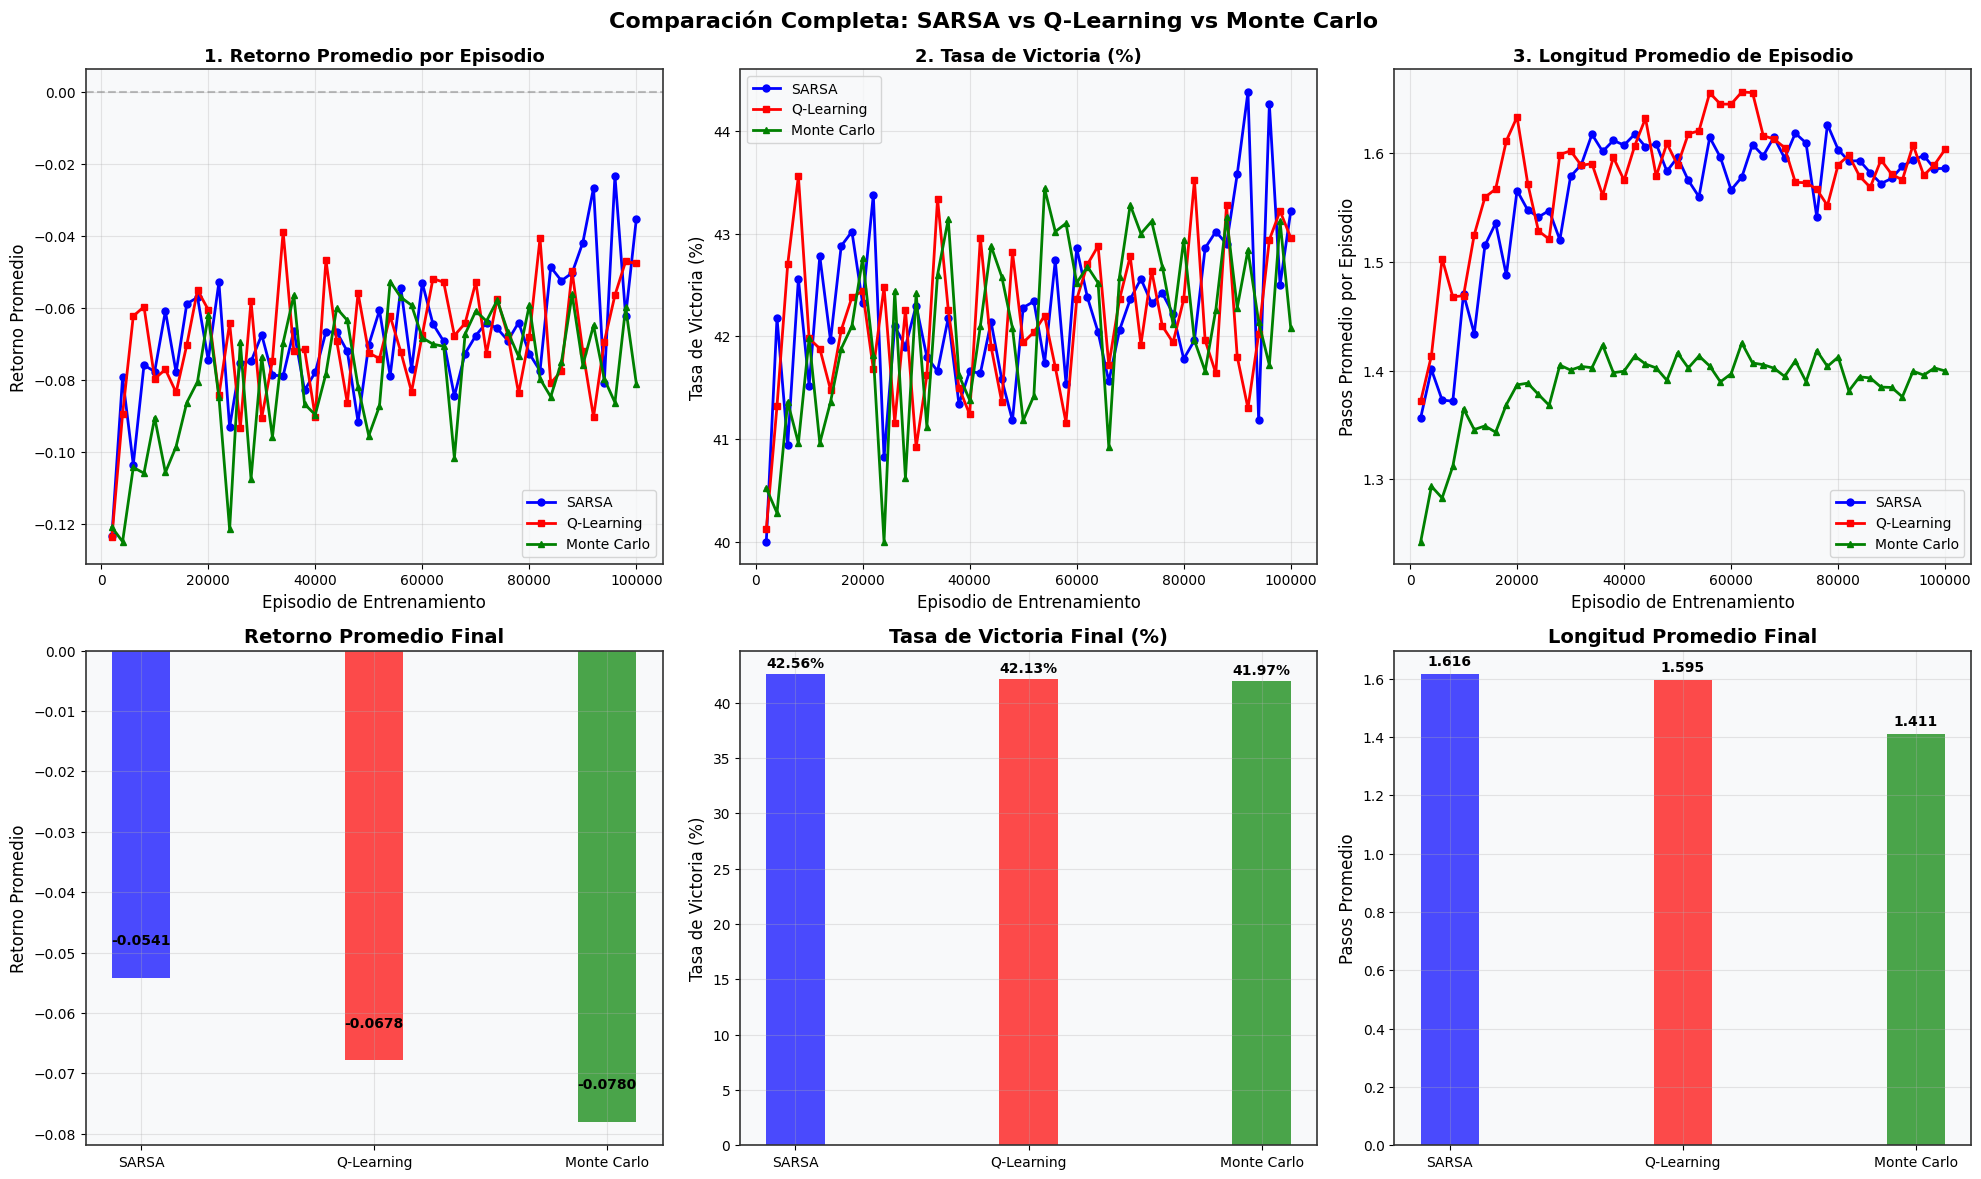

In [149]:
fig1 = plot_three_agents_comparison(sarsa_agent, qlearning_agent, mc_agent)
plt.show()

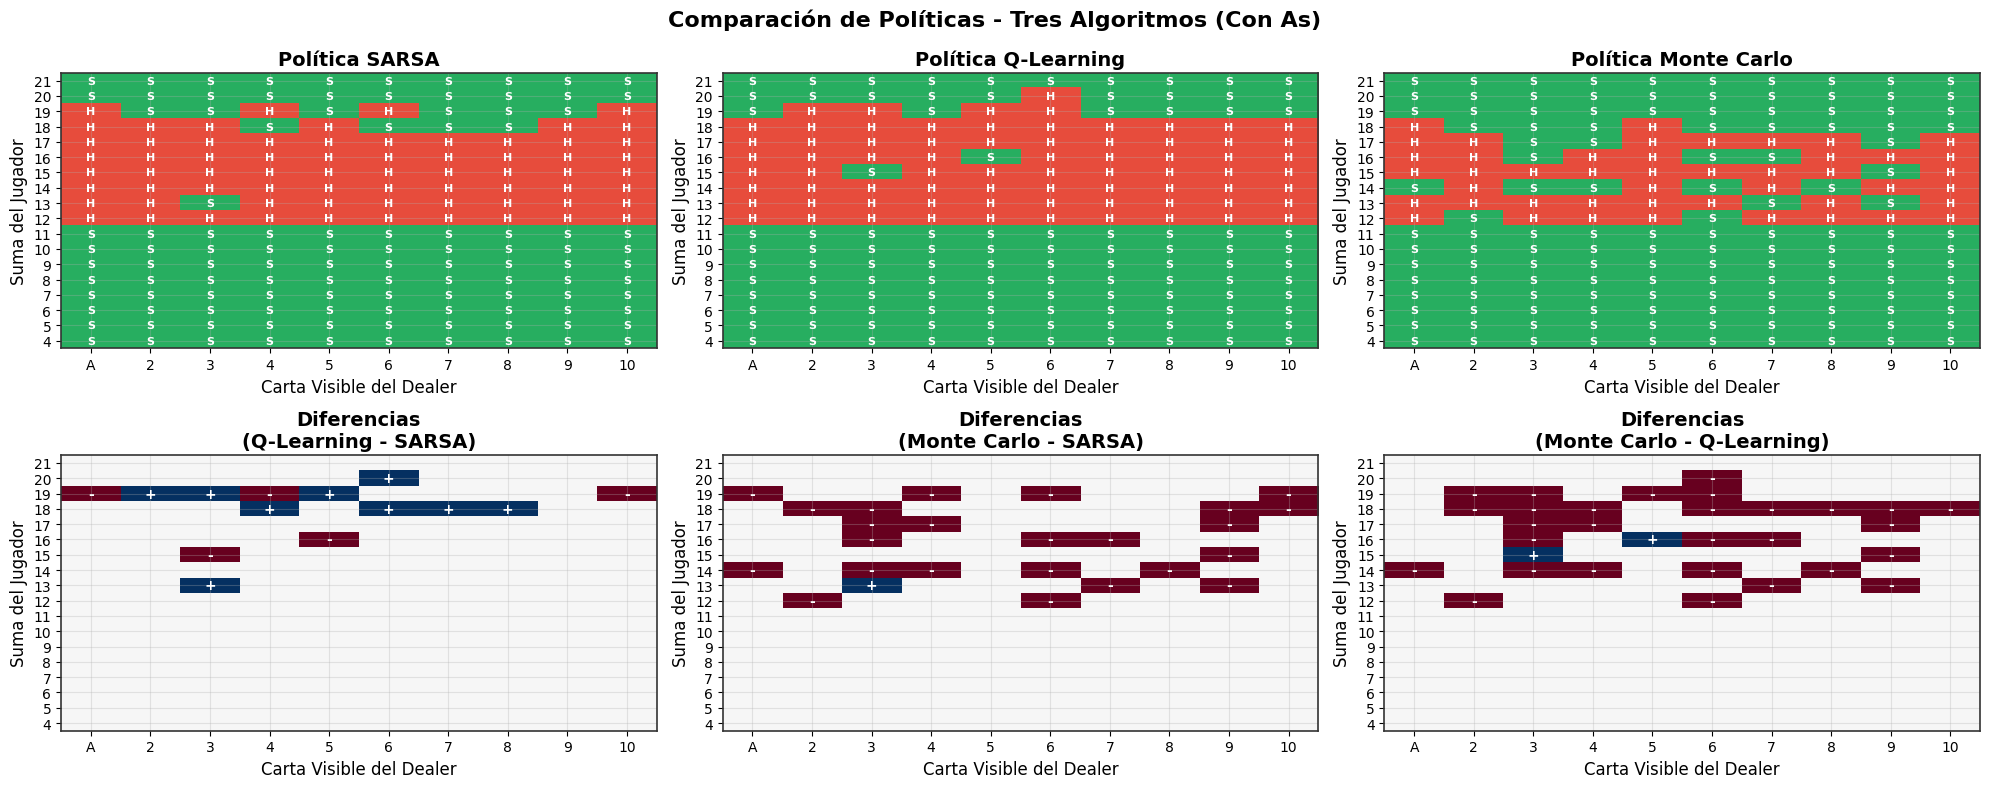

In [150]:
fig2 = plot_policy_comparison_three(sarsa_agent, qlearning_agent, mc_agent, usable_ace=True)
plt.show()

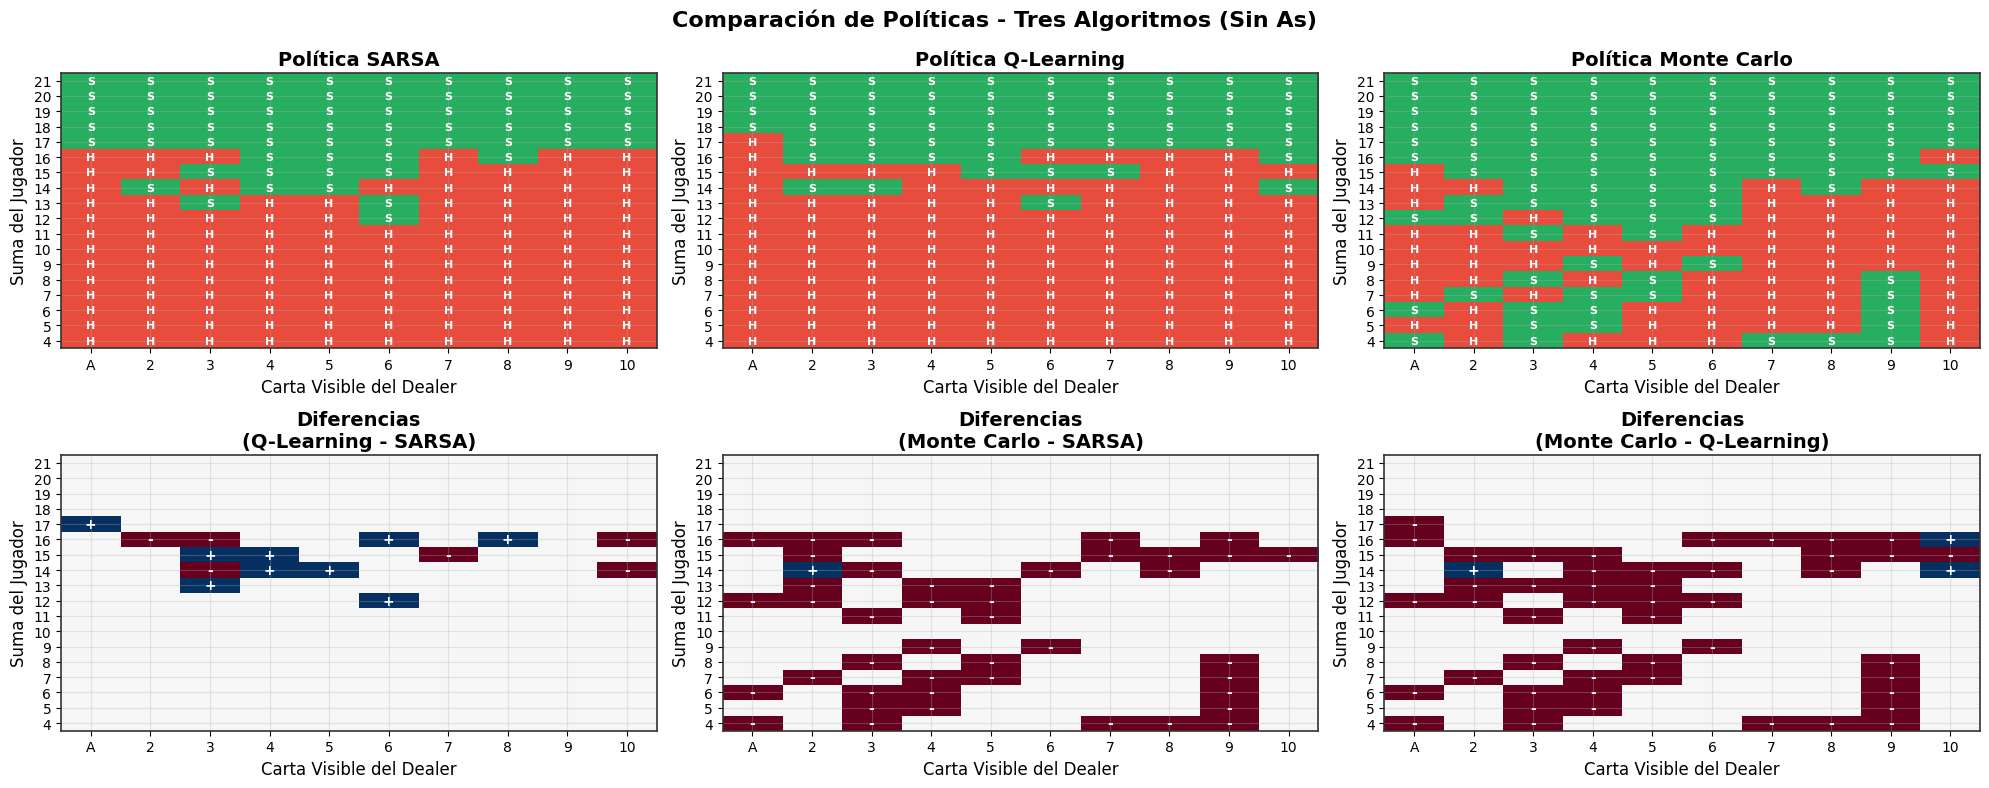

In [151]:
fig2 = plot_policy_comparison_three(sarsa_agent, qlearning_agent, mc_agent, usable_ace=False)
plt.show()